# Necessaries imports and packages

In [1]:
!pip install -U pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-4.1.1-py2.py3-none-any.whl size=456008642 sha256=021f7b45670dfa543e6bc82d8c1f20f25f021006cd235071601aec075dbedb40
  Stored in directory: /root/.cache/pip/wheels/f4/ca/ea/203f40b3e935bbf99bee851c2f4a87d22996ab8212d367ce58
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, but you have pyspark 4.1.1 which is incompatible.


In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

sc = spark.sparkContext

import os
from pyspark.sql.functions import count, col, expr
import math
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

from math import isclose
from operator import add, and_

from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
from pyspark.mllib.linalg import SparseVector
import numpy as np
from scipy.stats import spearmanr


#from pyspark.ml.linalg import SparseVector
#from pyspark import StorageLevel



# Dataset download

In [3]:
# Change username and key with your credentials to download the dataset
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [4]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 97% 1.03G/1.06G [00:18<00:01, 22.6MB/s]
100% 1.06G/1.06G [00:19<00:00, 60.0MB/s]


In [5]:
!unzip amazon-books-reviews.zip

Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


# Dataset

In [6]:
# Used if you don't want to randomly sample data
limit_size = 300000

# Used if you want to randomly sample data
fraction = 0.1
seed = 1
random_sampling = False # Set to True if you want to sample data randomly

In [7]:
df = spark.read.csv(
    "/content/Books_rating.csv",
    header=True,
    inferSchema=True
)

In [8]:
if not random_sampling:
  df = df.limit(limit_size)
else:
  df = df.sample(
      withReplacement=False,
      fraction = fraction,
      seed = seed
  )

In [9]:
df.printSchema()
df.show(5)

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)

+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/

# Dataset cleaning

In [10]:
# Selecting only the useful columns
df_clean = df.select(
    "Id",
    "User_id",
    "Title"
)

# Remove data with null values
df_clean = df_clean.dropna(subset=["Id", "User_id", "Title"])

# Generating nodes and edges

In [11]:
# Repartition data so that rows with same user id end up in same partition
reviews = df_clean.repartition("User_id")
reviews.rdd.getNumPartitions()

2

In [12]:
# Build pairs of book reviewd by the same user

bookpairs = (
    reviews.alias("Reviews_1")
    # Join reviews on user id
    .join(
        reviews.alias("Reviews_2"),
        F.col("Reviews_1.User_id") == F.col("Reviews_2.User_id")
    )
    # Remove rows with same book
    .filter(F.col("Reviews_1.Id") != F.col("Reviews_2.Id"))

    # Select only the book id column
    .select(
        F.col("Reviews_1.Id").alias("book_1"),
        F.col("Reviews_2.Id").alias("book_2")
    )
)

In [13]:
# Count how many times a couple (book_1, book_2) has been reviewed
weighted_edges = bookpairs.groupBy("book_1", "book_2") \
    .count() \
    .withColumnRenamed("count", "weight")

# Take only those pairs that have been reviewed at least twitce
weighted_edges = weighted_edges.filter(F.col("weight") >= 2)

In [14]:
# Extract all books
books = weighted_edges.select("book_1").union(
    weighted_edges.select("book_2")
).distinct()

# RDD
books_rdd = books.rdd.map(lambda r: r[0])

# Assign an integer to books
books_rdd = books_rdd.zipWithIndex()

# Collect data in driver as map and broadcast to workers
bookmap = sc.broadcast(books_rdd.collectAsMap())

In [15]:
n_books = max(bookmap.value.values()) + 1
print("Number of books:", n_books)

Number of books: 5641


In [16]:
# Create edges in the form of (source, (destination, weigth))
arcs = weighted_edges.rdd.map(
    lambda r: (
        bookmap.value[r["book_1"]],
        (bookmap.value[r["book_2"]], r["weight"])
    )
)

print("Number of edges:", arcs.count())

Number of edges: 148800


In [17]:
# Build the adjacency matrix

def build_matrix(book, neighbours):
    '''
    book = source node, row of matrix
    neighbours = list of (destination node, weight)
    '''

    sorted_neighbours = sorted(neighbours, key=lambda x: x[0]) # Sort neighbours by destination node ID to ensure indices are strictly increasing for Spase Vector

    indices = [n[0] for n in sorted_neighbours] # Indices of books
    values = [float(n[1]) for n in sorted_neighbours] # Weigth of edges

    total_weight = sum(values)

    # Normalization
    if total_weight > 0:
        values = [v / total_weight for v in values]

    # Create a SparseVector of length n_books, with non-zero values in position "indices"
    vector = SparseVector(n_books, indices, values)

    return IndexedRow(book, vector)

rows = arcs.groupByKey().mapValues(list) \
    .map(lambda x: build_matrix(x[0], x[1]))

matrix = IndexedRowMatrix(rows, n_books, n_books)

In [19]:
# Since the rank of a node depends on the nodes pointing to it, we take the transpose
transposed_matrix = matrix.toCoordinateMatrix() \
    .transpose() \
    .toIndexedRowMatrix()

# Pagerank

In [20]:
def pagerank(matrix, n, beta=0.85, tolerance=1e-5, max_iterations=100, topic = None):

    # Uniform inizialization
    rank = np.ones(n) / n

    if topic is None:
        # PageRank
        v = np.ones(n) / n
    else:
        # Topic-Sensitive PageRank
        v = topic.copy()
        v = v / v.sum()

    # Teleport term (1 - beta) * v
    teleport = sc.broadcast((1 - beta) * v)


    for it in range(1, max_iterations):

        # Broadcast of current rank
        rank_broadcast = sc.broadcast(rank)

        # Matrix-vector product: Mr
        update = (
            matrix.rows
             .map(lambda row: (
                 row.index,
                 row.vector.dot(rank_broadcast.value)
             ))
             .sortByKey()
             .collect()
        )


        Mr = SparseVector(n, update).toArray()

        # PageRank
        new_rank = beta * Mr + teleport.value

        # L2 norm
        dist = np.linalg.norm(new_rank - rank)

        print(f"{it}) dist: {dist}")

        rank = new_rank

        # Convergence check
        if dist < tolerance:
            print("Convergence achieved...")
            break

    return rank

In [21]:
%%time
rank_vector = pagerank(transposed_matrix, n_books)

1) dist: 0.03857940946088374
2) dist: 0.020813424192000995
3) dist: 0.009801714396425949
4) dist: 0.006891244050149036
5) dist: 0.004327103639266566
6) dist: 0.003153455915249896
7) dist: 0.002095510335017091
8) dist: 0.0015594668069688238
9) dist: 0.0010640751417384136
10) dist: 0.0008109912260645671
11) dist: 0.0005671405361327524
12) dist: 0.0004445899904625415
13) dist: 0.0003204323956549659
14) dist: 0.00025854903266451216
15) dist: 0.0001929380066326073
16) dist: 0.0001594787291962932
17) dist: 0.00012309380492716074
18) dist: 0.0001034032443161322
19) dist: 8.205928334351396e-05
20) dist: 6.953847867948247e-05
21) dist: 5.6318382358846975e-05
22) dist: 4.7908789640642664e-05
23) dist: 3.934771713928782e-05
24) dist: 3.351366838343157e-05
25) dist: 2.77863233063363e-05
26) dist: 2.3668474590395396e-05
27) dist: 1.9750218080581028e-05
28) dist: 1.6817817837817493e-05
29) dist: 1.4096535742388334e-05
30) dist: 1.1998674723047571e-05
31) dist: 1.0089319196384801e-05
32) dist: 8.5846

## Results

In [22]:
# Get map  id -> book_id and sort it
inverse_bookmap = {v: k for k, v in bookmap.value.items()}
top_indices = np.argsort(-rank_vector)[:20]

# Build list (Id, score)
top_data = [
    (inverse_bookmap[idx], float(rank_vector[idx]))
    for idx in top_indices
]

# Build dataframe with top 20 books
top_rank_df = spark.createDataFrame(
    top_data,
    ["Id", "PageRankScore"]
)

top_books = top_rank_df.join(
    df_clean.select("Id", "Title").distinct(),
    on="Id",
    how="left"
)

top_books.orderBy(F.desc("PageRankScore")) \
           .select("Id", "Title", "PageRankScore") \
           .show(20, truncate=False)

+----------+----------------------------------------------------------------+---------------------+
|Id        |Title                                                           |PageRankScore        |
+----------+----------------------------------------------------------------+---------------------+
|B000NWU3I4|The Hobbitt, or there and back again; illustrated by the author.|0.010260468158186677 |
|0460112872|Jane Eyre (Everyman's Classics)                                 |0.008325847340812797 |
|0681994851|Jane Eyre                                                       |0.008325847340812797 |
|B000GY0PV4|The Two Towers                                                  |0.008174206251222945 |
|B000N28H2I|The Two Towers                                                  |0.008174206251222945 |
|B000TZ19TC|Fahrenheit 451                                                  |0.006337600334993276 |
|B000GL8UMI|Fahrenheit 451                                                  |0.006331792606897691 |


# Topic sensitive Pagerank

In [23]:
df_book = spark.read.csv(
    "/content/books_data.csv",
    header=True,
    inferSchema=True
)

In [24]:
df_book = df_book.select(
    "Title",
    "categories"
)

# Remove data with null values
df_book = df_book.dropna(subset=["Title", "categories"])

## Choosing topic

In [25]:
topic = "Religion"

In [26]:
# Cleaning title since it is not reliable as Id or ISBN
df_clean = df_clean.withColumn(
    "title_clean",
    F.lower(F.trim(F.col("Title")))
)

df_book = df_book.withColumn(
    "title_clean",
    F.lower(F.trim(F.col("Title")))
)

In [27]:
books_full = df_clean.join(
    df_book.select("title_clean", "categories"),
    on="title_clean",
    how="left"
)

In [28]:
topic_books = books_full.filter(
    F.col("categories").rlike("(?i)"+topic)
).select("Id").distinct()

In [29]:
topic_ids = [
    bookmap.value[row["Id"]]
    for row in topic_books.collect()
    if row["Id"] in bookmap.value
]

v = np.zeros(n_books)

for idx in topic_ids:
    v[idx] = 1.0

v = v / v.sum()


In [30]:
print("Topic size:", len(topic_ids))
print("Non-zero entries in v:", np.count_nonzero(v))


Topic size: 212
Non-zero entries in v: 212


In [31]:
%%time
rank_topic = pagerank(
    transposed_matrix,
    n_books,
    beta=0.85,
    topic=v
)


1) dist: 0.039946860006446566
2) dist: 0.02118884383285044
3) dist: 0.01027872946543185
4) dist: 0.006960239264972793
5) dist: 0.004734208724997079
6) dist: 0.003381635157330766
7) dist: 0.002447030446474254
8) dist: 0.0018582470854543367
9) dist: 0.0013614651483719997
10) dist: 0.0011011038951710354
11) dist: 0.0008111450804743688
12) dist: 0.000690227391814587
13) dist: 0.0005131679907752843
14) dist: 0.00045096461761783533
15) dist: 0.0003395505752096119
16) dist: 0.0003032179449397748
17) dist: 0.00023135024146504166
18) dist: 0.00020780607802365847
19) dist: 0.00016044398844391328
20) dist: 0.00014422446599382174
21) dist: 0.00011244385691187319
22) dist: 0.00010095228912340674
23) dist: 7.931060663568043e-05
24) dist: 7.108631860888703e-05
25) dist: 5.617426513949172e-05
26) dist: 5.027551918081538e-05
27) dist: 3.9904192658476665e-05
28) dist: 3.567627498401929e-05
29) dist: 2.840978375207107e-05
30) dist: 2.538345963017991e-05
31) dist: 2.0262701380614717e-05
32) dist: 1.809897

## Results

In [32]:
# Get map  id -> book_id and sort it
inverse_bookmap = {v: k for k, v in bookmap.value.items()}
top_indices = np.argsort(-rank_topic)[:20]

# Build list (Id, score)
top_data = [
    (inverse_bookmap[idx], float(rank_topic[idx]))
    for idx in top_indices
]

# Build dataframe with top 20 books
top_rank_df = spark.createDataFrame(
    top_data,
    ["Id", "PageRankScore"]
)

top_books = top_rank_df \
    .join(
        df_clean.select("Id", "Title").distinct(),
        on="Id",
        how="left"
    ) \
    .join(
        books_full.select("Id", "categories").distinct(),
        on="Id",
        how="left"
    )
top_books.orderBy(F.desc("PageRankScore")) \
    .select("Id", "Title", "categories", "PageRankScore") \
    .show(20, truncate=False)


+----------+-------------------------------------------------------------------------------------------------------------------+----------------------+---------------------+
|Id        |Title                                                                                                              |categories            |PageRankScore        |
+----------+-------------------------------------------------------------------------------------------------------------------+----------------------+---------------------+
|0664221939|Animal Gospel                                                                                                      |['Religion']          |0.014421503038560992 |
|B000HKRIJO|Mere Christianity                                                                                                  |['Religion']          |0.011769056190861672 |
|B0006YT9ZM|Soren Kierkegaard, (Makers of contemporary theology)                                                               |['

# HITS

In [33]:
def hits(matrix, transposed_matrix, n, tolerance=1e-6, max_iterations=100):

    # Uniform inizialization
    hubs = np.ones(n)
    authorities = np.ones(n)

    # L2
    hubs = hubs / np.linalg.norm(hubs)
    authorities = authorities / np.linalg.norm(authorities)

    for it in range(1, max_iterations + 1):

        # Update authorities: a = M^T h
        hubs_b = sc.broadcast(hubs)

        a_update = (
            transposed_matrix.rows
               .map(lambda row: (
                   row.index,
                   row.vector.dot(hubs_b.value)
               ))
               .sortByKey()
               .collect()
        )

        new_authorities = SparseVector(n, a_update).toArray()
        new_authorities = new_authorities / np.linalg.norm(new_authorities)

        # Update hubs: h = M a
        auth_b = sc.broadcast(new_authorities)

        h_update = (
            matrix.rows
             .map(lambda row: (
                 row.index,
                 row.vector.dot(auth_b.value)
             ))
             .sortByKey()
             .collect()
        )

        new_hubs = SparseVector(n, h_update).toArray()
        new_hubs = new_hubs / np.linalg.norm(new_hubs)

        dist_auth = np.linalg.norm(new_authorities - authorities)
        dist_hub = np.linalg.norm(new_hubs - hubs)

        print(f"{it}) Auth dist: {dist_auth}   Hub dist: {dist_hub}")

        authorities = new_authorities
        hubs = new_hubs

        # Convergence check
        if max(dist_auth, dist_hub) < tolerance:
            print("Convergence achieved...")
            break

    return authorities, hubs

In [34]:
%%time
authorities, hubs = hits(matrix, transposed_matrix, n_books)

1) Auth dist: 1.1987595081762878   Hub dist: 0.7149872377653551
2) Auth dist: 0.46275297737956184   Hub dist: 0.3669542976791682
3) Auth dist: 0.3223418764241817   Hub dist: 0.29311043185434393
4) Auth dist: 0.26508751751049464   Hub dist: 0.23422508083124285
5) Auth dist: 0.20150526231071192   Hub dist: 0.16941964337122706
6) Auth dist: 0.14006057146018785   Hub dist: 0.11454123259648308
7) Auth dist: 0.09312776952820032   Hub dist: 0.07556844864850334
8) Auth dist: 0.06137410921273053   Hub dist: 0.049993832521458705
9) Auth dist: 0.040905377075171966   Hub dist: 0.033652736193896554
10) Auth dist: 0.02785551326643301   Hub dist: 0.023205072617049273
11) Auth dist: 0.019455481505586653   Hub dist: 0.016413176646737148
12) Auth dist: 0.013927121722102004   Hub dist: 0.011880147982928206
13) Auth dist: 0.010181664718201597   Hub dist: 0.008761699398516275
14) Auth dist: 0.0075661312531328856   Hub dist: 0.006552947414253593
15) Auth dist: 0.00568934629660048   Hub dist: 0.0049495241206

## Results

In [35]:
top_auth_idx = np.argsort(-authorities)[:20]
top_hub_idx = np.argsort(-hubs)[:20]

In [36]:
# Build list (Id, score auth)
top_auth_data = [
    (inverse_bookmap[idx], float(authorities[idx]))
    for idx in top_auth_idx
]

# Build dataframe with top 20 authorities books
top_auth_df = spark.createDataFrame(
    top_auth_data,
    ["Id", "AuthorityScore"]
)

top_books_auth = top_auth_df.join(
    df_clean.select("Id", "Title").distinct(),
    on="Id",
    how="left"
)

top_books_auth.orderBy(F.desc("AuthorityScore")) \
              .select("Id", "Title", "AuthorityScore") \
              .show(20, truncate=False)

+----------+------------------------------------------------------------------------------------------------------+---------------------+
|Id        |Title                                                                                                 |AuthorityScore       |
+----------+------------------------------------------------------------------------------------------------------+---------------------+
|0664221939|Animal Gospel                                                                                         |0.9998061506967684   |
|0764225529|Systematic Theology, Vol. 2, God/Creation                                                             |0.0056140248815819685|
|B00005VOED|A confederacy of dunces                                                                               |0.00524092894092845  |
|B000EB850C|The Courage to Be                                                                                     |0.005083550417353415 |
|B0006S3U1W|100 amazing facts abou

In [37]:
# Build list (Id, score hub)
top_hub_data = [
    (inverse_bookmap[idx], float(hubs[idx]))
    for idx in top_hub_idx
]

# Build dataframe with top 20 hub books
top_hub_df = spark.createDataFrame(
    top_hub_data,
    ["Id", "HubScore"]
)

top_books_hub = top_hub_df.join(
    df_clean.select("Id", "Title").distinct(),
    on="Id",
    how="left"
)

top_books_hub.orderBy(F.desc("HubScore")) \
             .select("Id", "Title", "HubScore") \
             .show(20, truncate=False)

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Id        |Title                                                                                                                                                                                              |HubScore          |
+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|020148384X|The Great Dinosaur Extinction Controversy (Helix Books)                                                                                                                                            |0.1392707953824447|
|020163211X|Lives in the Shadow With J. Krishnamurti                                    

# Graphs

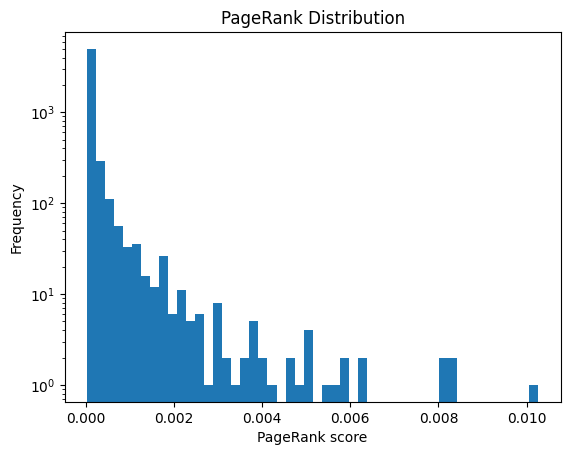

In [38]:
plt.figure()
plt.hist(rank_vector, bins=50)
plt.yscale("log")
plt.title("PageRank Distribution")
plt.xlabel("PageRank score")
plt.ylabel("Frequency")
plt.show()

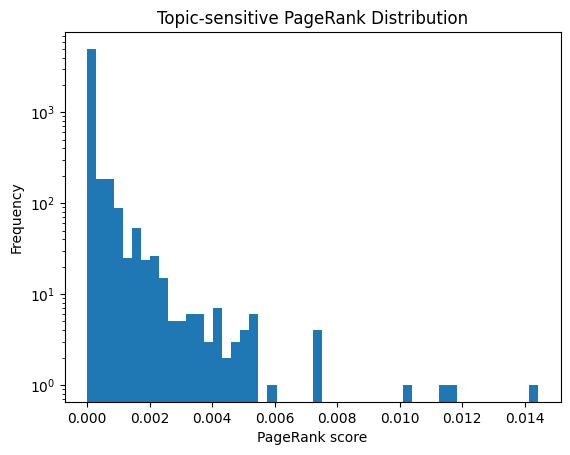

In [39]:
plt.figure()
plt.hist(rank_topic, bins=50)
plt.yscale("log")
plt.title("Topic-sensitive PageRank Distribution")
plt.xlabel("PageRank score")
plt.ylabel("Frequency")
plt.show()

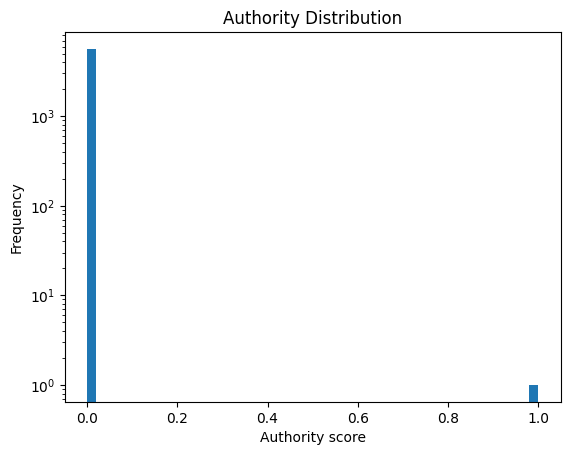

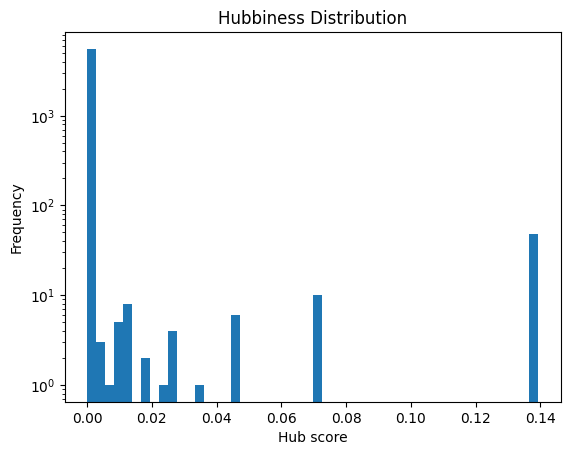

In [40]:
plt.figure()
plt.hist(authorities, bins=50)
plt.yscale("log")
plt.title("Authority Distribution")
plt.xlabel("Authority score")
plt.ylabel("Frequency")
plt.show()

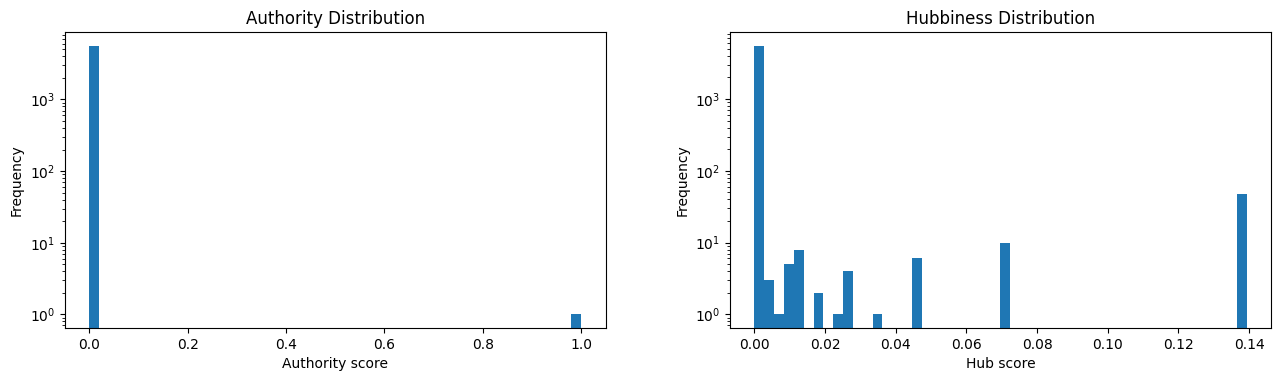

In [41]:
plt.figure()
plt.hist(hubs, bins=50)
plt.yscale("log")
plt.title("Hubbiness Distribution")
plt.xlabel("Hub score")
plt.ylabel("Frequency")
plt.show()

In [44]:
print("Spearman PR vs Authority:", spearmanr(rank_vector, authorities))
print("Spearman PR vs Hub:", spearmanr(rank_vector, hubs))
print("Spearman Authority vs Hub:", spearmanr(authorities, hubs))

Spearman PR vs Authority: SignificanceResult(statistic=np.float64(0.33716176959004607), pvalue=np.float64(5.396583658659127e-150))
Spearman PR vs Hub: SignificanceResult(statistic=np.float64(-0.08530717495163487), pvalue=np.float64(1.3861078795750116e-10))
Spearman Authority vs Hub: SignificanceResult(statistic=np.float64(0.5240090128275533), pvalue=np.float64(0.0))


In [45]:
def compute_ranks(scores):
    # argsort return the indices that would sort an array
    order = np.argsort(-scores)

    # create an empty array
    ranks = np.empty_like(order)

    # assigns the positions
    ranks[order] = np.arange(len(scores))

    return ranks


In [54]:
pr_pos = compute_ranks(rank_vector)
ts_pr_pos = compute_ranks(rank_topic)
auth_pos = compute_ranks(authorities)
hub_pos = compute_ranks(hubs)

In [55]:
print("PR vs Topic PR:",
      spearmanr(pr_pos, ts_pr_pos))

print("PR vs Authority:",
      spearmanr(pr_pos, auth_pos))

print("Authority vs Hub:",
      spearmanr(auth_pos, hub_pos))


PR vs Topic PR: SignificanceResult(statistic=np.float64(0.4722069753447047), pvalue=np.float64(0.0))
PR vs Authority: SignificanceResult(statistic=np.float64(0.33702646617891613), pvalue=np.float64(7.216234890224522e-150))
Authority vs Hub: SignificanceResult(statistic=np.float64(0.5238818562519728), pvalue=np.float64(0.0))
